## Notebook D2: Exploring Relationship Between Water Infrastructure and Oil Wells in Kern County

**By Melody Ng**

In this notebook, I focus on exploring the relationship between the location of oil and gas wells and canals in Kern County, the distance between wells and canals, and the census tracts and canals with the most closeby wells located near them.

In [1]:
## importing libraries

# reading data
import pandas as pd
import geopandas as gpd
import numpy as np
import fiona
import osmnx as ox
import shapely
import io

# plots/charts
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
#import plotly.io as pio
    # pio.templates.default = "ggplot2"
    # options: seaborn, simple_white, plotly, plotly_white, plotly_dark
    # presentation, xgridoff, ygridoff, gridon, none

# maps
import contextily as ctx
import folium

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
## loading files

# canals
canals = gpd.read_file('Canals_Kern_24k.shp')

# watercourse
watercourse = gpd.read_file('berkeley-s74962-geojson.json')

# OG wells
kern_wells = gpd.read_file('kernOGwells.geojson')

# oil wells and CalEnvironscreen data
oilenv = gpd.read_file('OilCES4.geojson')

In [5]:
## adjusting projection
oilenv = oilenv.to_crs("EPSG:4326")
kern_wells = kern_wells.to_crs("EPSG:4326")
canals = canals.to_crs("EPSG:4326")
watercourse = watercourse.to_crs("EPSG:4326")

In [6]:
watercourse.sample(3)

,id,NAME,TYPE,BURIED,geometry
42,s74962.43,Cross Valley Canal,canal,N,"MULTIPOLYGON (((-119.26944 35.34638, -119.2694..."
106,s74962.107,Kern Island Canal,canal,Y,"MULTIPOLYGON (((-119.00989 35.37343, -119.0098..."
62,s74962.63,Cross Valley Canal,canal,Y,"MULTIPOLYGON (((-119.17108 35.34663, -119.1710..."


Before I can begin assigning canals to their nearest well, I need to break down the linestring geometry provided in the canals geodataframe and convert them into sets of points within/along the linestring -- so that I can do a point-to-point match.

In [7]:
## creating lat and long columns using linestring geometry for canals
def f(frame):
    xy = frame.geometry.xy
    longs = xy[0].tolist()
    lats = xy[1].tolist()
    return [list(z) for z in zip(lats, longs)]

canals['coords'] = canals.apply(f, axis=1)

In [8]:
## checking results
canals.sample()

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords
47,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.34794 35.15810, -119.34833 35...","[[35.15810093762344, -119.34794423113968], [35..."


In [9]:
## expanding 'coords' so each lat/long pair is assigned to and individual 'CANAL' name
canals2 = canals.explode('coords', ignore_index=False)

In [10]:
## adjusting projection
canals2 = canals2.to_crs("EPSG:4326")

In [11]:
## checking results: 1. comparing number of rows in gdfs
print(canals.shape)
print(canals2.shape)

(64, 12)
(9764, 12)


In [12]:
## checking results: 2. comparing count of rows for each canal in gdfs
canals[canals.CANAL=='CALIFORNIA AQUEDUCT']

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords
47,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.34794 35.15810, -119.34833 35...","[[35.15810093762344, -119.34794423113968], [35..."
48,0,0,0,0,25332.699219,206,7363,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.66683 35.55721, -119.66671 35...","[[35.55721164016379, -119.66682780530539], [35..."
49,0,0,0,0,41084.500000,207,7482,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.52961 35.37496, -119.52936 35...","[[35.37496185271356, -119.52960787883916], [35..."
50,0,0,0,0,22466.900391,208,7607,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-118.87593 34.94196, -118.87366 34...","[[34.94195523322125, -118.87593129668642], [34..."
52,283,288,0,0,12154.200195,236,7333,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.72522 35.65197, -119.72518 35...","[[35.651968205571855, -119.72522405613468], [3..."
54,374,283,0,0,51671.601562,292,7333,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.86903 35.78898, -119.86883 35...","[[35.78897702009324, -119.86902846959897], [35..."
63,557,487,0,0,37988.000000,343,7618,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-118.70766 34.82624, -118.70742 34...","[[34.82623951561728, -118.70766016844686], [34..."


In [13]:
canals2[canals2.CANAL=='CALIFORNIA AQUEDUCT']

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords
47,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.34794 35.15810, -119.34833 35...","[35.15810093762344, -119.34794423113968]"
47,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.34794 35.15810, -119.34833 35...","[35.157100992215035, -119.34832640211188]"
47,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.34794 35.15810, -119.34833 35...","[35.1557599365974, -119.34875194758371]"
47,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.34794 35.15810, -119.34833 35...","[35.15514965212524, -119.34890818622556]"
47,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-119.34794 35.15810, -119.34833 35...","[35.15478973976083, -119.34892566668314]"
...,...,...,...,...,...,...,...,...,...,...,...,...
63,557,487,0,0,37988.000000,343,7618,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-118.70766 34.82624, -118.70742 34...","[34.81903071579731, -118.69164407316205]"
63,557,487,0,0,37988.000000,343,7618,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-118.70766 34.82624, -118.70742 34...","[34.81876842498701, -118.69148775143807]"
63,557,487,0,0,37988.000000,343,7618,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-118.70766 34.82624, -118.70742 34...","[34.81849332240988, -118.69128772074968]"
63,557,487,0,0,37988.000000,343,7618,CALIFORNIA AQUEDUCT,0,1,"LINESTRING (-118.70766 34.82624, -118.70742 34...","[34.8182649194379, -118.69107091759527]"


In [14]:
## checking new coords column
canals2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9764 entries, 0 to 63
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FNODE_      9764 non-null   int64   
 1   TNODE_      9764 non-null   int64   
 2   LPOLY_      9764 non-null   int64   
 3   RPOLY_      9764 non-null   int64   
 4   LENGTH      9764 non-null   float64 
 5   CANAL24CA_  9764 non-null   int64   
 6   CANAL24CA1  9764 non-null   int64   
 7   CANAL       9606 non-null   object  
 8   FED         9764 non-null   int64   
 9   STATE       9764 non-null   int64   
 10  geometry    9764 non-null   geometry
 11  coords      9764 non-null   object  
dtypes: float64(1), geometry(1), int64(8), object(2)
memory usage: 991.7+ KB


In [15]:
## converting coords to str (for some reason it says its not a str when I try to use str.strip())
canals2['coords'] = canals2['coords'].astype(str)

In [16]:
## remove brackets from 'coord' values
canals2['coords'] = canals2['coords'].str.replace('[','').str.replace(']','')

/tmp/ipykernel_58/1126559100.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  canals2['coords'] = canals2['coords'].str.replace('[','').str.replace(']','')


In [17]:
## checking new coords column again
canals2.sample(3)

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords
58,524,526,0,0,41256.601562,337,1,LOS ANGELES AQUEDUCT,0,0,"LINESTRING (-118.01776 35.49996, -118.01740 35...","35.42263495369458, -118.02231915953949"
23,0,0,0,0,30270.099609,81,7498,NEW RIM DITCH,0,0,"LINESTRING (-118.97689 35.17921, -118.97682 35...","35.1110778323362, -119.05175377105924"
34,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,"LINESTRING (-118.97546 35.37481, -118.97482 35...","35.35771091581761, -118.92799772680901"


Now I need to split the 'coords' column into separate latitude and longitude columns, before I can convert them into point geometry.

In [18]:
## splitting 'coords' column into separate lat & long columns
canals2[['lat','lon']] = canals2['coords'].str.split(',', expand=True)

In [19]:
## checking
canals2.sample(2)

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords,lat,lon
38,0,0,0,0,23261.599609,173,7394,CALLOWAY CANAL,0,0,"LINESTRING (-119.27817 35.55817, -119.27822 35...","35.537154070971326, -119.26729679347693",35.537154070971326,-119.26729679347693
23,0,0,0,0,30270.099609,81,7498,NEW RIM DITCH,0,0,"LINESTRING (-118.97689 35.17921, -118.97682 35...","35.13366630685853, -119.10407335469489",35.13366630685853,-119.10407335469489


In [20]:
canals2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9764 entries, 0 to 63
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FNODE_      9764 non-null   int64   
 1   TNODE_      9764 non-null   int64   
 2   LPOLY_      9764 non-null   int64   
 3   RPOLY_      9764 non-null   int64   
 4   LENGTH      9764 non-null   float64 
 5   CANAL24CA_  9764 non-null   int64   
 6   CANAL24CA1  9764 non-null   int64   
 7   CANAL       9606 non-null   object  
 8   FED         9764 non-null   int64   
 9   STATE       9764 non-null   int64   
 10  geometry    9764 non-null   geometry
 11  coords      9764 non-null   object  
 12  lat         9764 non-null   object  
 13  lon         9764 non-null   object  
dtypes: float64(1), geometry(1), int64(8), object(4)
memory usage: 1.1+ MB


In [21]:
## converting new lat,long values to float
canals2['lat'] = canals2['lat'].astype(float)
canals2['lon'] = canals2['lon'].astype(float)

In [22]:
## confirming
canals2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9764 entries, 0 to 63
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FNODE_      9764 non-null   int64   
 1   TNODE_      9764 non-null   int64   
 2   LPOLY_      9764 non-null   int64   
 3   RPOLY_      9764 non-null   int64   
 4   LENGTH      9764 non-null   float64 
 5   CANAL24CA_  9764 non-null   int64   
 6   CANAL24CA1  9764 non-null   int64   
 7   CANAL       9606 non-null   object  
 8   FED         9764 non-null   int64   
 9   STATE       9764 non-null   int64   
 10  geometry    9764 non-null   geometry
 11  coords      9764 non-null   object  
 12  lat         9764 non-null   float64 
 13  lon         9764 non-null   float64 
dtypes: float64(3), geometry(1), int64(8), object(2)
memory usage: 1.1+ MB


In [23]:
# converting lat and lon columns into a POINT geometry column
points = gpd.GeoDataFrame(canals2, geometry=gpd.points_from_xy(x=canals2.lon, y=canals2.lat), crs='EPSG:4326')
canals2.sample()

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords,lat,lon
53,0,0,0,0,104129.0,287,108,FRIANT-KERN CANAL,1,0,POINT (-119.23491 35.61918),"35.61917782044731, -119.2349125114996",35.619178,-119.234913


I'm going to overlay the canals geodataframe with canals linestring geometry over the new geodataframe with the broken down canals point geometry to confirm this has been done correctly.

Text(0.5, 1.0, 'Canals in Kern County')

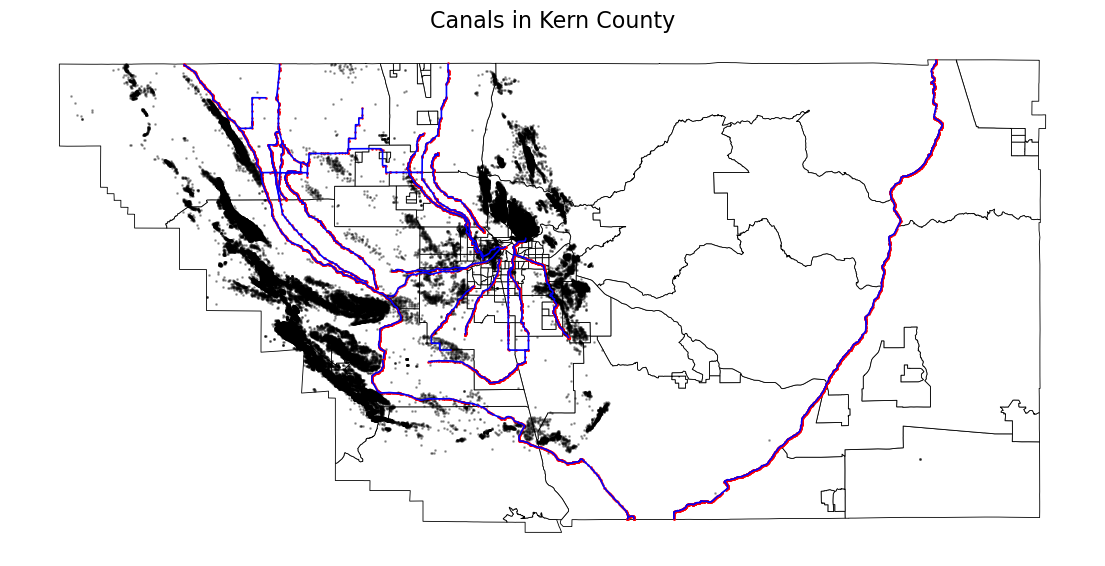

In [24]:
## checking to see if points pulled from linetring match
fig,ax = plt.subplots(figsize=(14,12))

# tracts
oilenv.plot(ax=ax,
            facecolor='white',
            edgecolor='black',
            lw=0.6)
# canals
canals.plot(ax=ax,
            linestyle='solid',
            linewidth=1.2,
            color='blue',
            alpha=1)

canals2.plot(ax=ax,
            marker='.',
            markersize=3,
            color='red',
            alpha=.9)

# OG wells
kern_wells.plot(ax=ax,
                marker='.',
                markersize=4,
                color='black',
                alpha=.3)
                
ax.axis('off')
ax.set_title("Canals in Kern County",fontsize=16)

Looks promising -- like the disaggregated lat/long coordinate pairs for each linestring have been assigned to the right canal. Now I will use a Ball Tree to assign the nearest canal to each well, since there are so many observations in the dataset and other methods have caused my notebook to crash. I will also need to make sure I calculate the haversine distance, given that the distance I'm calculating is between two points on a sphere using longitude and latitude coordinates.

In [25]:
# loading libraries to use balltree
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from sklearn.neighbors import BallTree

In [26]:
## defining functions
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest: index in right_gdf that corresponds to the closest point
    # dist: distance between the nearest neighbors (in miles)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right gdf that are closest to points in left gdf
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance
    if return_dist:
        # Convert to meters from radians
        # earth_radius = 6371000  # meters
        earth_radius = 3958.8   # miles
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

The function has been written, so I can now load my prepped geodataframes and do nearest neighbor analysis for wells and canals.

In [27]:
# Find closest canal geopoint for each well and the haversine distance
closest_canal = nearest_neighbor(kern_wells, canals2, return_dist=True)

In [28]:
closest_canal.sample(4)

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords,lat,lon,distance
16787,0,0,0,0,25332.699219,206,7363,CALIFORNIA AQUEDUCT,0,1,POINT (-119.65717 35.52164),"35.521640458920864, -119.65717477459287",35.521640,-119.657175,3.886298
57392,374,283,0,0,51671.601562,292,7333,CALIFORNIA AQUEDUCT,0,1,POINT (-119.76931 35.69324),"35.69324169361292, -119.76931377867206",35.693242,-119.769314,0.644880
17511,0,0,0,0,25332.699219,206,7363,CALIFORNIA AQUEDUCT,0,1,POINT (-119.66363 35.53697),"35.536970619492116, -119.66363342887816",35.536971,-119.663633,4.917199
70138,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,POINT (-119.32075 35.08807),"35.08807499556056, -119.32074784146249",35.088075,-119.320748,2.061567


Next, I want to identify the ranges for the distance column to customize a legend scale that qualitatively ranks exposure levels to environmental risk by proximity of a well to a canal.

In [29]:
## getting ranges
print(closest_canal['distance'].min())
print(closest_canal['distance'].max())
print(closest_canal['distance'].quantile([0.25,0.5,0.75]))

0.002656991955996022
20.434949572860784
0.25    2.030380
0.50    4.163078
0.75    5.570402
Name: distance, dtype: float64


The nearest well to a canal is only .003 miles (4 meters) away from it while the farthest nearest well to a canal is ~20.4 miles away. On average, most wells seem to be within 4 miles of a canal. Now, to define a new variable that qualitatively scales distance.

In [75]:
## new variable
closest_canal['Exposure'] = "1: 10 to 20 miles away"
closest_canal.loc[closest_canal['distance'] < 10, 'Exposure'] = '2: 5 to 10 miles away'
closest_canal.loc[closest_canal['distance'] < 5, 'Exposure'] = '3: 2 to 5 miles away'
closest_canal.loc[closest_canal['distance'] < 2, 'Exposure'] = '4: 1 to 2 miles away'
closest_canal.loc[closest_canal['distance'] < 1, 'Exposure'] = '5: 0.50 to 1 mile away'
closest_canal.loc[closest_canal['distance'] < .5, 'Exposure'] = '6: 0.25 to 0.50 mile away'
closest_canal.loc[closest_canal['distance'] < .25, 'Exposure'] = '7: 0.25 mile or less away'
closest_canal

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords,lat,lon,distance,Exposure
0,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.618909,3: 2 to 5 miles away
1,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.348006,3: 2 to 5 miles away
2,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.237711,3: 2 to 5 miles away
3,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.441736,3: 2 to 5 miles away
4,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.290983,3: 2 to 5 miles away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96722,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,POINT (-119.20188 35.07529),"35.07528715603352, -119.20188034613332",35.075287,-119.201880,0.836198,5: 0.50 to 1 mile away
96723,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,POINT (-119.18958 35.07526),"35.07525873263542, -119.18957976083958",35.075259,-119.189580,0.720854,5: 0.50 to 1 mile away
96724,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,POINT (-119.18958 35.07526),"35.07525873263542, -119.18957976083958",35.075259,-119.189580,0.842058,5: 0.50 to 1 mile away
96725,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,POINT (-119.20188 35.07529),"35.07528715603352, -119.20188034613332",35.075287,-119.201880,0.994204,5: 0.50 to 1 mile away


Now to create a table that sums up the total wells by distance to nearest canal so I can use it to create a bar chart.

In [76]:
## value counts
exposure = closest_canal.value_counts('Exposure').reset_index(name='Count')
exposure 

,Exposure,Count
0,3: 2 to 5 miles away,38790
1,2: 5 to 10 miles away,33997
2,4: 1 to 2 miles away,13062
3,5: 0.50 to 1 mile away,7175
4,6: 0.25 to 0.50 mile away,2080
5,7: 0.25 mile or less away,1489
6,1: 10 to 20 miles away,134


I want the colorscale for the bars on the chart to match the colorscale for the legend on the map I'll be creating so I need to create a custom color scale for the chart.

In [77]:
## creating custom palette for bars on plot using number of exposure levels to generate hex codes
iter = 7
palette = list((sns.color_palette("YlOrBr", iter).as_hex()))
print(palette)

['#fff7bc', '#fee390', '#fec34f', '#fe9829', '#eb6f14', '#cb4b02', '#983404']


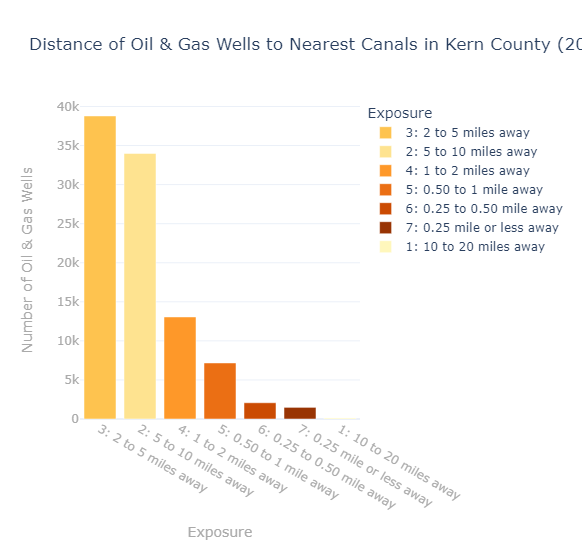

In [170]:
## plotting results

# setting template
import plotly.io as pio
pio.templates.default = "plotly_white"
    # options: seaborn, simple_white, plotly, plotly_white, plotly_dark
    # presentation, xgridoff, ygridoff, gridon, none

# plot 
fig = px.bar(exposure,
        x='Exposure',
        y='Count',
        title="Distance of Oil & Gas Wells to Nearest Canals in Kern County (2022)",
        text_auto = False,
        height=550,
        width=750,
        color='Exposure',
        color_discrete_map={'1: 10 to 20 miles away':'#fff7bc', '2: 5 to 10 miles away':'#fee390', '3: 2 to 5 miles away':'#fec34f', '4: 1 to 2 miles away':'#fe9829', '5: 0.50 to 1 mile away':'#eb6f14', '6: 0.25 to 0.50 mile away':'#cb4b02', '7: 0.25 mile or less away':'#983404'},
                 labels={
                'Count': 'Number of Oil & Gas Wells',
                'index': 'Distance to Nearest Canal',
        })

# bar label
fig.update_traces(textposition='outside',textfont_size=10,textfont_color='black')

# axes labels
fig.update_yaxes(title_font_size=14,title_font_color='#aaa',tickfont_color='#aaa',tickfont_size=12)
fig.update_xaxes(title_font_size=14,title_font_color='#aaa',tickfont_color='#aaa',tickfont_size=12)

# show the figure
fig.show()

#save 
fig.write_html("welltocanaldistance2.html")

Seems like it worked! I was able to assign colors to the bars based on the "Exposure" level. Now I want to map these exposure distributions by colorcoding the oil wells using this same color scheme. Checking to see what I need to do with the existing geodataframe to make this possible.

In [34]:
## counting the frequency of locations in gdf
closest_canal['geometry'].value_counts()

POINT (-119.55690 35.39325)    3487
POINT (-119.37741 35.11412)    3230
POINT (-119.63845 35.46775)    2647
POINT (-119.67815 35.57478)    2589
POINT (-119.69954 35.61721)    2331
                               ... 
POINT (-119.34833 35.15710)       1
POINT (-119.35971 35.19137)       1
POINT (-119.36576 35.13077)       1
POINT (-119.36466 35.13086)       1
POINT (-119.17424 35.07585)       1
Name: geometry, Length: 1720, dtype: int64

I can see that the geodataframe produced by the function returns only information about the canals and that to create a map that colorcodes wells by distance, I need to append the "distance" and "Exposure" columns in this geodataframe to the original wells geodataframe. But first I have to confirm that the wells in the "closest_canal" geodataframe are indexed/aligned with the original "kern_wells" geodataframe.

In [79]:
closest_canal

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords,lat,lon,distance,Exposure
0,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.618909,3: 2 to 5 miles away
1,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.348006,3: 2 to 5 miles away
2,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.237711,3: 2 to 5 miles away
3,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.441736,3: 2 to 5 miles away
4,0,0,0,0,18496.300781,169,7477,EAST SIDE CANAL,0,0,POINT (-118.90428 35.30449),"35.304491860716126, -118.90428280829941",35.304492,-118.904283,4.290983,3: 2 to 5 miles away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96722,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,POINT (-119.20188 35.07529),"35.07528715603352, -119.20188034613332",35.075287,-119.201880,0.836198,5: 0.50 to 1 mile away
96723,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,POINT (-119.18958 35.07526),"35.07525873263542, -119.18957976083958",35.075259,-119.189580,0.720854,5: 0.50 to 1 mile away
96724,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,POINT (-119.18958 35.07526),"35.07525873263542, -119.18957976083958",35.075259,-119.189580,0.842058,5: 0.50 to 1 mile away
96725,0,0,0,0,62670.398438,205,7485,CALIFORNIA AQUEDUCT,0,1,POINT (-119.20188 35.07529),"35.07528715603352, -119.20188034613332",35.075287,-119.201880,0.994204,5: 0.50 to 1 mile away


In [80]:
kern_wells

,Operator,WellStatus,WellType,Latitude,Longitude,geometry,distance,Exposure
0,California Resources Production Corporation,Idle,OG,35.402748,-118.857201,POINT (-118.85720 35.40275),4.618909,3: 2 to 5 miles away
1,California Resources Production Corporation,Idle,OG,35.397060,-118.860001,POINT (-118.86000 35.39706),4.348006,3: 2 to 5 miles away
2,California Resources Production Corporation,Idle,OG,35.393887,-118.860725,POINT (-118.86073 35.39389),4.237711,3: 2 to 5 miles away
3,California Resources Production Corporation,Idle,OG,35.397015,-118.858070,POINT (-118.85807 35.39701),4.441736,3: 2 to 5 miles away
4,California Resources Production Corporation,Idle,OG,35.395214,-118.860275,POINT (-118.86028 35.39521),4.290983,3: 2 to 5 miles away
...,...,...,...,...,...,...,...,...
96722,California Resources Production Corporation,Plugged,OG,35.053963,-119.208061,POINT (-119.20806 35.05396),0.836198,5: 0.50 mile to 1 mile away
96723,California Resources Production Corporation,Plugged,OG,35.054073,-119.191025,POINT (-119.19102 35.05407),0.720854,5: 0.50 mile to 1 mile away
96724,California Resources Production Corporation,Plugged,OG,35.050400,-119.190819,POINT (-119.19082 35.05040),0.842058,5: 0.50 mile to 1 mile away
96725,California Resources Production Corporation,Plugged,OG,35.048664,-119.208069,POINT (-119.20807 35.04866),0.994204,5: 0.50 mile to 1 mile away


It seems like they are. Now I can append the "distance" and "Exposure" category columns to the wells geodataframe so I can produce a map colorcoding the wells by distance to the nearest canal.

In [81]:
## appending
kern_wells['distance'] = closest_canal['distance']
kern_wells['Exposure'] = closest_canal['Exposure']
kern_wells

,Operator,WellStatus,WellType,Latitude,Longitude,geometry,distance,Exposure
0,California Resources Production Corporation,Idle,OG,35.402748,-118.857201,POINT (-118.85720 35.40275),4.618909,3: 2 to 5 miles away
1,California Resources Production Corporation,Idle,OG,35.397060,-118.860001,POINT (-118.86000 35.39706),4.348006,3: 2 to 5 miles away
2,California Resources Production Corporation,Idle,OG,35.393887,-118.860725,POINT (-118.86073 35.39389),4.237711,3: 2 to 5 miles away
3,California Resources Production Corporation,Idle,OG,35.397015,-118.858070,POINT (-118.85807 35.39701),4.441736,3: 2 to 5 miles away
4,California Resources Production Corporation,Idle,OG,35.395214,-118.860275,POINT (-118.86028 35.39521),4.290983,3: 2 to 5 miles away
...,...,...,...,...,...,...,...,...
96722,California Resources Production Corporation,Plugged,OG,35.053963,-119.208061,POINT (-119.20806 35.05396),0.836198,5: 0.50 to 1 mile away
96723,California Resources Production Corporation,Plugged,OG,35.054073,-119.191025,POINT (-119.19102 35.05407),0.720854,5: 0.50 to 1 mile away
96724,California Resources Production Corporation,Plugged,OG,35.050400,-119.190819,POINT (-119.19082 35.05040),0.842058,5: 0.50 to 1 mile away
96725,California Resources Production Corporation,Plugged,OG,35.048664,-119.208069,POINT (-119.20807 35.04866),0.994204,5: 0.50 to 1 mile away


And now plotting the results.

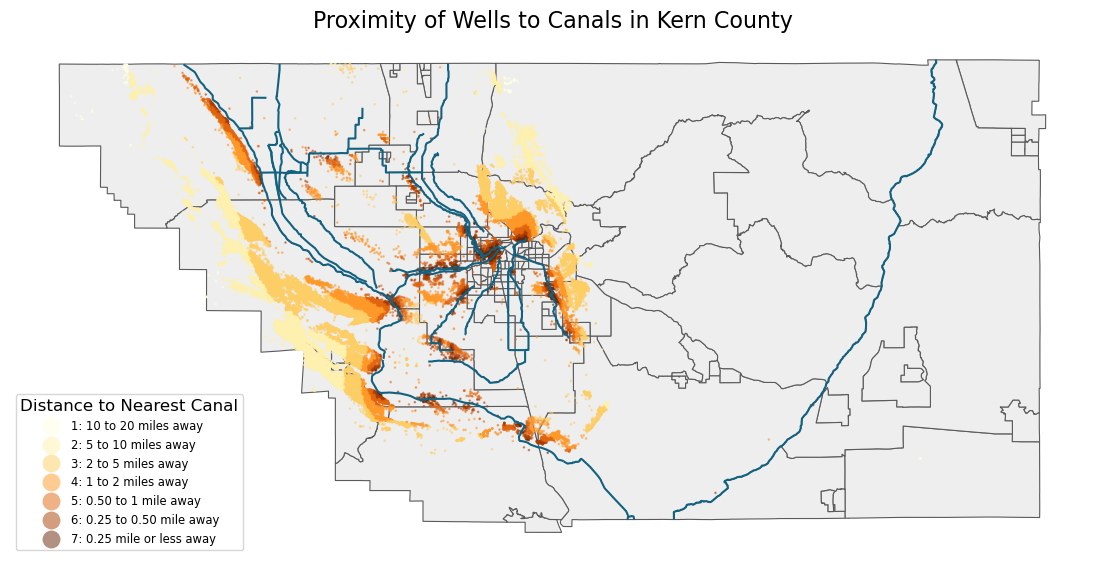

In [82]:
## plotting
fig,ax = plt.subplots(figsize=(14,12))

# tracts
oilenv.plot(ax=ax,
            facecolor='#eee',
            edgecolor='#5A5A5A',
            lw=.8)
# canals
canals.plot(ax=ax,
            linestyle='solid',
            linewidth=1.5,
            color='#126180',
            alpha=1)

# OG wells: color coded
kern_wells.plot(ax=ax,
                column='Exposure',
                marker='.',
                markersize=3,
                legend=True,
                legend_kwds={'loc':'lower left',
                                 'bbox_to_anchor':(0, 0), 'fmt':"{:.1f}",
                                 'markerscale':1.29, 
                                 'title_fontsize':'large', 
                                 'fontsize':'small'},   
                cmap='YlOrBr',
                alpha=.5)
                
ax.axis('off')
ax.set_title("Proximity of Wells to Canals in Kern County",fontsize=16)
ax.get_legend().set_title("Distance to Nearest Canal")

# saving
plt.savefig("wellstocanalsproximity.jpg", bbox_inches ='tight')

Producing a map with just the "Active" wells color-coded by distance.

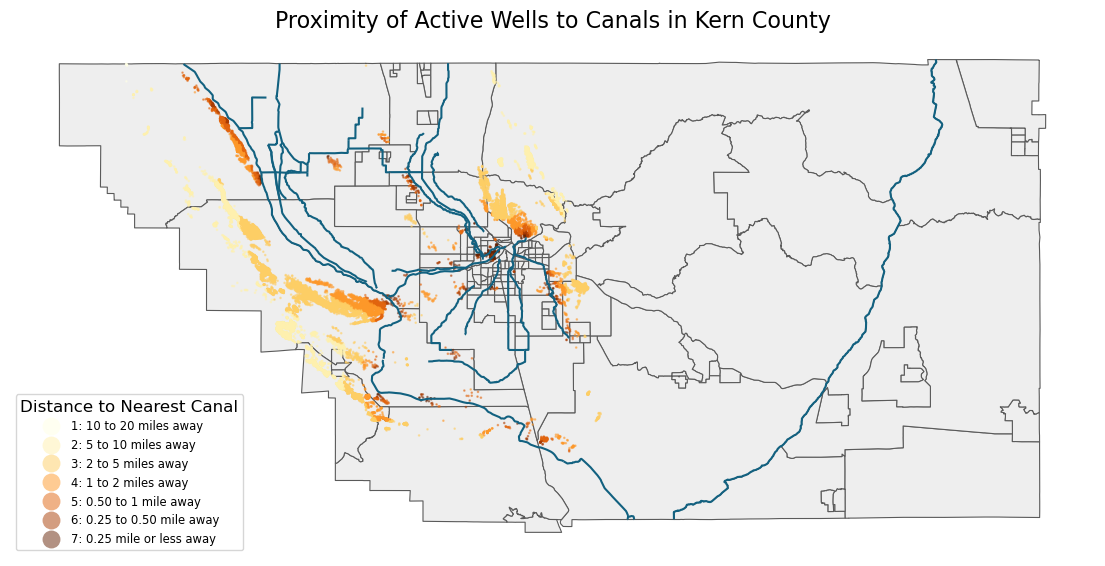

In [83]:
## plotting
fig,ax = plt.subplots(figsize=(14,12))

# tracts
oilenv.plot(ax=ax,
            facecolor='#eee',
            edgecolor='#5A5A5A',
            lw=.8)
# canals
canals.plot(ax=ax,
            linestyle='solid',
            linewidth=1.5,
            color='#126180',
            alpha=1)

# OG wells: color coded
kern_wells[kern_wells.WellStatus == 'Active'].plot(ax=ax,
                column='Exposure',
                marker='.',
                markersize=3,
                legend=True,
                legend_kwds={'loc':'lower left',
                                 'bbox_to_anchor':(0, 0), 'fmt':"{:.1f}",
                                 'markerscale':1.29, 
                                 'title_fontsize':'large', 
                                 'fontsize':'small'},   
                cmap='YlOrBr',
                alpha=.5)
                
ax.axis('off')
ax.set_title("Proximity of Active Wells to Canals in Kern County",fontsize=16)
ax.get_legend().set_title("Distance to Nearest Canal")

# saving
#plt.savefig("activewellstocanalsproximity.jpg", bbox_inches ='tight')

Now I want to create choropleth maps that identify census tracts by concentration of wells that are either a quarter- or a half-mile away from a canal, so I can identify the census tracts with the highest concentration of wells that are close to a canal. To do that I'll need to load the saved geodataframe merging CalEnviroScreen data to the subsetted oil wells data -- which assigns a census tract to each well.

In [84]:
## ID census tracts with the high concentration of wells .25 and .5 away
# load gdf with each well assigned a tract from the CalEnviroScreen dataset
oiltracts = gpd.read_file('Kern_wells_tracts.geojson')
oiltracts

,Operator,WellStatus,WellType,Latitude,Longitude,index_right,TotPop19,ApproxLoc,Tract,FIPS,...,SolWasteP,Asthma,AsthmaP,Cardiovas,CardiovasP,LowBirtWt,LowBirWP,Shape_Leng,Shape_Area,geometry
0,California Resources Production Corporation,Idle,OG,35.402748,-118.857201,1419.0,4220.0,Bakersfield,6029005104.0,06029005104.0,...,52.898053,58.53,67.385344,14.14,61.166500,4.48,38.183218,67625.561901,1.032451e+08,POINT (-118.85720 35.40275)
1,California Resources Production Corporation,Idle,OG,35.397060,-118.860001,1529.0,10642.0,Unincorporated Kern County area,6029001000.0,06029001000.0,...,0.000000,70.90,79.050349,17.32,77.642074,3.94,25.211701,27644.021538,4.665149e+07,POINT (-118.86000 35.39706)
2,California Resources Production Corporation,Idle,OG,35.393887,-118.860725,1529.0,10642.0,Unincorporated Kern County area,6029001000.0,06029001000.0,...,0.000000,70.90,79.050349,17.32,77.642074,3.94,25.211701,27644.021538,4.665149e+07,POINT (-118.86073 35.39389)
3,California Resources Production Corporation,Idle,OG,35.397015,-118.858070,1529.0,10642.0,Unincorporated Kern County area,6029001000.0,06029001000.0,...,0.000000,70.90,79.050349,17.32,77.642074,3.94,25.211701,27644.021538,4.665149e+07,POINT (-118.85807 35.39701)
4,California Resources Production Corporation,Idle,OG,35.395214,-118.860275,1529.0,10642.0,Unincorporated Kern County area,6029001000.0,06029001000.0,...,0.000000,70.90,79.050349,17.32,77.642074,3.94,25.211701,27644.021538,4.665149e+07,POINT (-118.86028 35.39521)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96722,California Resources Production Corporation,Plugged,OG,35.053963,-119.208061,1498.0,4199.0,Unincorporated Kern County area,6029003306.0,06029003306.0,...,96.013746,25.97,18.195414,11.69,43.644068,3.52,16.628176,177890.535308,1.073976e+09,POINT (-119.20806 35.05396)
96723,California Resources Production Corporation,Plugged,OG,35.054073,-119.191025,1498.0,4199.0,Unincorporated Kern County area,6029003306.0,06029003306.0,...,96.013746,25.97,18.195414,11.69,43.644068,3.52,16.628176,177890.535308,1.073976e+09,POINT (-119.19102 35.05407)
96724,California Resources Production Corporation,Plugged,OG,35.050400,-119.190819,1498.0,4199.0,Unincorporated Kern County area,6029003306.0,06029003306.0,...,96.013746,25.97,18.195414,11.69,43.644068,3.52,16.628176,177890.535308,1.073976e+09,POINT (-119.19082 35.05040)
96725,California Resources Production Corporation,Plugged,OG,35.048664,-119.208069,1498.0,4199.0,Unincorporated Kern County area,6029003306.0,06029003306.0,...,96.013746,25.97,18.195414,11.69,43.644068,3.52,16.628176,177890.535308,1.073976e+09,POINT (-119.20807 35.04866)


I need to merge this geodataframe which has the census tract for each well with the with the geodataframe with the distance and exposure levels, so that I can aggregate the number of wells by distance and exposure level by tract.

In [85]:
## merging wells distance gdf w/ CalEnviroScreen gdf so each well+ its distance to the 
## nearest canal is assigned to a tract
welltracts = kern_wells.merge(oiltracts, how='left', on='geometry')
welltracts.sample(3)

,Operator_x,WellStatus_x,WellType_x,Latitude_x,Longitude_x,geometry,distance,Exposure,Operator_y,WellStatus_y,...,SolWaste,SolWasteP,Asthma,AsthmaP,Cardiovas,CardiovasP,LowBirtWt,LowBirWP,Shape_Leng,Shape_Area
3535,Aera Energy LLC,Plugged,OG,35.518726,-119.766808,POINT (-119.76681 35.51873),5.387151,2: 5 to 10 miles away,Aera Energy LLC,Plugged,...,15.60,96.380298,29.49,24.065304,14.98,66.151545,5.07,54.272517,230543.991013,2.344339e+09
85626,Sentinel Peak Resources California LLC,Plugged,OG,35.230022,-119.619850,POINT (-119.61985 35.23002),6.478442,2: 5 to 10 miles away,Sentinel Peak Resources California LLC,Plugged,...,26.95,99.450172,25.70,17.746760,13.63,58.138086,5.39,61.945086,259228.671777,1.607709e+09
40318,"California Resources Elk Hills, LLC",Active,OG,35.287052,-119.406456,POINT (-119.40646 35.28705),1.246574,4: 1 to 2 miles away,"California Resources Elk Hills, LLC",Active,...,26.95,99.450172,25.70,17.746760,13.63,58.138086,5.39,61.945086,259228.671777,1.607709e+09


In [86]:
## taking a look at columns
welltracts.columns.to_list()

['Operator_x',
 'WellStatus_x',
 'WellType_x',
 'Latitude_x',
 'Longitude_x',
 'geometry',
 'distance',
 'Exposure',
 'Operator_y',
 'WellStatus_y',
 'WellType_y',
 'Latitude_y',
 'Longitude_y',
 'index_right',
 'TotPop19',
 'ApproxLoc',
 'Tract',
 'FIPS',
 'Pesticide',
 'PesticideP',
 'Tox_Rel',
 'Tox_Rel_P',
 'ImpWatBod',
 'ImpWatBodP',
 'DrinkWat',
 'DrinkWatP',
 'Cleanup',
 'CleanupP',
 'GWThreat',
 'GWThreatP',
 'SolWaste',
 'SolWasteP',
 'Asthma',
 'AsthmaP',
 'Cardiovas',
 'CardiovasP',
 'LowBirtWt',
 'LowBirWP',
 'Shape_Leng',
 'Shape_Area']

I'm going to remove some of the columns since they seem to be duplicates.

In [87]:
## keep essential columns
welltracts = welltracts[['Operator_y','WellStatus_y','WellType_y','distance','Exposure','ApproxLoc','Tract','FIPS','geometry','Latitude_y','Longitude_y','TotPop19','Pesticide','PesticideP','Tox_Rel','Tox_Rel_P','ImpWatBod','ImpWatBodP','DrinkWat','DrinkWatP','Cleanup','CleanupP','GWThreat','GWThreatP','SolWaste','SolWasteP','Asthma','AsthmaP','Cardiovas','CardiovasP','LowBirtWt','LowBirWP']]
welltracts

,Operator_y,WellStatus_y,WellType_y,distance,Exposure,ApproxLoc,Tract,FIPS,geometry,Latitude_y,...,GWThreat,GWThreatP,SolWaste,SolWasteP,Asthma,AsthmaP,Cardiovas,CardiovasP,LowBirtWt,LowBirWP
0,California Resources Production Corporation,Idle,OG,4.618909,3: 2 to 5 miles away,Bakersfield,6029005104.0,06029005104.0,POINT (-118.85720 35.40275),35.402748,...,15.00,59.604848,2.0,52.898053,58.53,67.385344,14.14,61.166500,4.48,38.183218
1,California Resources Production Corporation,Idle,OG,4.348006,3: 2 to 5 miles away,Unincorporated Kern County area,6029001000.0,06029001000.0,POINT (-118.86000 35.39706),35.397060,...,45.25,88.361282,0.0,0.000000,70.90,79.050349,17.32,77.642074,3.94,25.211701
2,California Resources Production Corporation,Idle,OG,4.237711,3: 2 to 5 miles away,Unincorporated Kern County area,6029001000.0,06029001000.0,POINT (-118.86073 35.39389),35.393887,...,45.25,88.361282,0.0,0.000000,70.90,79.050349,17.32,77.642074,3.94,25.211701
3,California Resources Production Corporation,Idle,OG,4.441736,3: 2 to 5 miles away,Unincorporated Kern County area,6029001000.0,06029001000.0,POINT (-118.85807 35.39701),35.397015,...,45.25,88.361282,0.0,0.000000,70.90,79.050349,17.32,77.642074,3.94,25.211701
4,California Resources Production Corporation,Idle,OG,4.290983,3: 2 to 5 miles away,Unincorporated Kern County area,6029001000.0,06029001000.0,POINT (-118.86028 35.39521),35.395214,...,45.25,88.361282,0.0,0.000000,70.90,79.050349,17.32,77.642074,3.94,25.211701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96928,California Resources Production Corporation,Plugged,OG,0.836198,5: 0.50 to 1 mile away,Unincorporated Kern County area,6029003306.0,06029003306.0,POINT (-119.20806 35.05396),35.053963,...,13.00,54.524323,15.0,96.013746,25.97,18.195414,11.69,43.644068,3.52,16.628176
96929,California Resources Production Corporation,Plugged,OG,0.720854,5: 0.50 to 1 mile away,Unincorporated Kern County area,6029003306.0,06029003306.0,POINT (-119.19102 35.05407),35.054073,...,13.00,54.524323,15.0,96.013746,25.97,18.195414,11.69,43.644068,3.52,16.628176
96930,California Resources Production Corporation,Plugged,OG,0.842058,5: 0.50 to 1 mile away,Unincorporated Kern County area,6029003306.0,06029003306.0,POINT (-119.19082 35.05040),35.050400,...,13.00,54.524323,15.0,96.013746,25.97,18.195414,11.69,43.644068,3.52,16.628176
96931,California Resources Production Corporation,Plugged,OG,0.994204,5: 0.50 to 1 mile away,Unincorporated Kern County area,6029003306.0,06029003306.0,POINT (-119.20807 35.04866),35.048664,...,13.00,54.524323,15.0,96.013746,25.97,18.195414,11.69,43.644068,3.52,16.628176


Creating a "quarter" dummy variable to identify whether a well is or is not a quarter mile away from a canal, so I can more easily create a choropleth map using this variable.

In [88]:
## creating dummy
welltracts['quarter'] = 'False'
welltracts.loc[welltracts['Exposure'] == '7: 0.25 mile or less away', 'quarter'] = 'True'
welltracts.sample(4)

,Operator_y,WellStatus_y,WellType_y,distance,Exposure,ApproxLoc,Tract,FIPS,geometry,Latitude_y,...,GWThreatP,SolWaste,SolWasteP,Asthma,AsthmaP,Cardiovas,CardiovasP,LowBirtWt,LowBirWP,quarter
23607,Aera Energy LLC,Plugged,OG,4.349086,3: 2 to 5 miles away,Unincorporated Kern County area,6029003304.0,06029003304.0,POINT (-119.70805 35.44581),35.445808,...,94.753445,26.95,99.450172,25.70,17.746760,13.63,58.138086,5.39,61.945086,False
78914,Chevron U.S.A. Inc.,Plugged,OG,5.989549,2: 5 to 10 miles away,Unincorporated Kern County area,6029003304.0,06029003304.0,POINT (-119.55315 35.20385),35.203850,...,94.753445,26.95,99.450172,25.70,17.746760,13.63,58.138086,5.39,61.945086,False
45762,California Resources Production Corporation,Active,OG,2.250231,3: 2 to 5 miles away,Unincorporated Kern County area,6029005103.0,06029005103.0,POINT (-119.03455 35.46541),35.465412,...,92.777686,6.90,81.741123,69.77,78.439681,18.68,83.275174,5.60,66.833462,False
58402,Chevron U.S.A. Inc.,Plugged,OG,1.116286,4: 1 to 2 miles away,Unincorporated Kern County area,6029004500.0,06029004500.0,POINT (-119.72582 35.61718),35.617180,...,95.998672,15.60,96.380298,29.49,24.065304,14.98,66.151545,5.07,54.272517,False


In [89]:
## confirming assignment has been done correctly
quarterprop = welltracts.value_counts(['quarter']).reset_index(name='Count')
quarterprop

,quarter,Count
0,False,95438
1,True,1495


Seems like the the dummy has been correctly assigned to each well. Creating another "half mile" dummy variable to identify whether a well is or is not a half mile away from a canal.

In [114]:
## creating dummy
welltracts['half'] = 'False'
welltracts.loc[welltracts['Exposure'] == '6: 0.25 to 0.50 mile away', 'half'] = 'True'
welltracts.sample(4)

,Operator_y,WellStatus_y,WellType_y,distance,Exposure,ApproxLoc,Tract,FIPS,geometry,Latitude_y,...,SolWaste,SolWasteP,Asthma,AsthmaP,Cardiovas,CardiovasP,LowBirtWt,LowBirWP,quarter,half
20373,Aera Energy LLC,Plugged,OG,4.419284,3: 2 to 5 miles away,Unincorporated Kern County area,6029003304.0,06029003304.0,POINT (-119.71193 35.45211),35.452110,...,26.95,99.450172,25.70,17.746760,13.63,58.138086,5.39,61.945086,False,False
41310,"California Resources Elk Hills, LLC",Active,OG,2.387848,3: 2 to 5 miles away,Unincorporated Kern County area,6029003304.0,06029003304.0,POINT (-119.41953 35.25443),35.254425,...,26.95,99.450172,25.70,17.746760,13.63,58.138086,5.39,61.945086,False,False
92133,E & B Natural Resources Management Corporation,Active,OG,2.517821,3: 2 to 5 miles away,Shafter,6029003900.0,06029003900.0,POINT (-119.07966 35.50927),35.509266,...,1.50,42.313860,63.74,73.005982,18.51,82.739282,-999.00,-999.000000,False,False
54176,Chevron U.S.A. Inc.,Plugged,OG,1.387840,4: 1 to 2 miles away,Unincorporated Kern County area,6029005103.0,06029005103.0,POINT (-119.00356 35.44766),35.447659,...,6.90,81.741123,69.77,78.439681,18.68,83.275174,5.60,66.833462,False,False


Now to get the count of wells that are within .25 miles of a canal for each tract in table form.

In [92]:
# count whether quarter=true for each tract
quartermi = (welltracts.groupby('Tract')[['quarter']]
       .apply(lambda group: group.apply(pd.Series.value_counts))
       .fillna(0)).reset_index()

In [99]:
## dropping tract rows that don't have wells a quarter mi from canals; sorting by ascending
quartermi = quartermi[quartermi.level_1 !='False']
quartermi.sort_values(by='quarter',ascending=False,inplace=True)
quartermi

,Tract,level_1,quarter
11,6029000507.0,True,454
81,6029005103.0,True,234
43,6029003304.0,True,156
89,6029006201.0,True,147
38,6029003204.0,True,113
9,6029000506.0,True,50
50,6029003700.0,True,49
53,6029003804.0,True,40
22,6029002400.0,True,29
76,6029004500.0,True,28


In [115]:
## checking to see whether this worked
print(quartermi2.quarter.sum())

1495


Great -- seems like it has. Now to also get the count of wells that are within .5 miles of a canal for each tract in table form.

In [116]:
# count whether half=true for each tract
halfmi = (welltracts.groupby('Tract')[['half']]
       .apply(lambda group: group.apply(pd.Series.value_counts))
       .fillna(0)).reset_index()
halfmi

,Tract,level_1,half
0,6029000101.0,False,71
1,6029000102.0,False,7
2,6029000200.0,False,10
3,6029000300.0,True,1
4,6029000400.0,True,8
...,...,...,...
98,6029006304.0,False,24
99,6029006401.0,False,2
100,6029006404.0,False,2
101,6029006404.0,True,1


In [117]:
## dropping tract rows that don't have wells a half mi from canals; sorting by ascending
halfmi = halfmi[halfmi.level_1 !='False']
halfmi.sort_values(by='half',ascending=False,inplace=True)
halfmi

/tmp/ipykernel_58/3129442191.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Tract,level_1,half
83,6029005103.0,True,609
45,6029003304.0,True,402
78,6029004500.0,True,315
40,6029003204.0,True,139
13,6029000507.0,True,94
47,6029003306.0,True,93
89,6029006007.0,True,58
63,6029003809.0,True,47
91,6029006201.0,True,45
24,6029002400.0,True,41


In [118]:
## checking to see whether this worked
print(halfmi.half.sum())

2080


Also seems like it's worked too. Now to merge these two columns to the geodataframe with the census tracts so that each tract is assigned the number of wells that is a quarter a mile away from a canal.

In [119]:
## merging quartermile tract counts with CES4 gdf
distancedensity = oilenv.merge(quartermi, how='left', on='Tract')
distancedensity.sample(3)

,TotPop19,ApproxLoc,Tract,FIPS,Pesticide,PesticideP,Tox_Rel,Tox_Rel_P,ImpWatBod,ImpWatBodP,...,Cardiovas,CardiovasP,LowBirtWt,LowBirWP,Shape_Leng,Shape_Area,Count,geometry,level_1,quarter
140,3713,Olde Stockdale,6029002807.0,06029002807.0,0.000000,0.000000,230.218330,37.121780,0.0,0.0,...,17.62,79.150050,4.26,32.755966,7226.657834,3.140972e+06,0,"POLYGON ((-119.07448 35.33765, -119.07447 35.3...",NaN,NaN
12,2221,Boron,6029005600.0,06029005600.0,0.000000,0.000000,169.834300,31.507877,0.0,0.0,...,15.18,67.298106,7.50,93.879908,40380.886584,5.898147e+07,0,"POLYGON ((-117.68584 35.05807, -117.67664 35.0...",NaN,NaN
38,8674,Delano,6029004902.0,06029004902.0,1.378354,44.758621,0.232057,3.250813,0.0,0.0,...,23.05,95.264207,5.85,72.081088,6668.179179,2.644848e+06,0,"POLYGON ((-119.23202 35.77586, -119.24201 35.7...",NaN,NaN


I'm Seeing some 'NaN' values probably where there are no wells within .25 mi of a canal. so replacing with '0'.

In [120]:
## replacing NaNs
distancedensity['quarter'] = distancedensity['quarter'].fillna(0)
distancedensity.sample(3)

,TotPop19,ApproxLoc,Tract,FIPS,Pesticide,PesticideP,Tox_Rel,Tox_Rel_P,ImpWatBod,ImpWatBodP,...,Cardiovas,CardiovasP,LowBirtWt,LowBirWP,Shape_Leng,Shape_Area,Count,geometry,level_1,quarter
113,7552,Bakersfield,6029003000.0,06029003000.0,0.0,0.0,38.859400,16.379095,0.0,0.0,...,20.78,89.543868,5.26,59.186554,6527.095949,2.662319e+06,0,"POLYGON ((-119.00303 35.32494, -119.02121 35.3...",NaN,0.0
44,7835,Bakersfield,6029003114.0,06029003114.0,0.0,0.0,39.956200,16.579145,0.0,0.0,...,19.05,84.421735,4.62,41.724403,7646.983338,3.502915e+06,1,"POLYGON ((-119.03447 35.31041, -119.03065 35.2...",NaN,0.0
48,3411,Bakersfield,6029000902.0,06029000902.0,0.0,0.0,8.989647,8.639660,0.0,0.0,...,17.38,77.941176,4.39,35.604311,4940.582890,1.325428e+06,0,"POLYGON ((-118.96760 35.41273, -118.96566 35.4...",NaN,0.0


In [121]:
## checking to see whether the merge was done correctly
print(distancedensity.quarter.sum())

1495.0


Now to merge the half mile density table to the geodataframe.

In [122]:
## merging quartermile tract counts with CES4 gdf
distancedensity = distancedensity.merge(halfmi, how='left', on='Tract')
distancedensity.sample(3)

,TotPop19,ApproxLoc,Tract,FIPS,Pesticide,PesticideP,Tox_Rel,Tox_Rel_P,ImpWatBod,ImpWatBodP,...,LowBirtWt,LowBirWP,Shape_Leng,Shape_Area,Count,geometry,level_1_x,quarter,level_1_y,half
16,7970,Bakersfield,6029003122.0,06029003122.0,0.030548,17.965517,58.929768,19.254814,0.0,0.0,...,5.88,72.850911,6528.496569,2.663460e+06,0,"POLYGON ((-119.00306 35.29589, -119.02123 35.2...",NaN,0.0,NaN,NaN
7,5027,Ridgecrest,6029005402.0,06029005402.0,0.000000,0.000000,0.106211,2.613153,0.0,0.0,...,4.10,28.958173,9684.088752,5.227690e+06,0,"POLYGON ((-117.70554 35.62253, -117.70546 35.6...",NaN,0.0,NaN,NaN
48,3411,Bakersfield,6029000902.0,06029000902.0,0.000000,0.000000,8.989647,8.639660,0.0,0.0,...,4.39,35.604311,4940.582890,1.325428e+06,0,"POLYGON ((-118.96760 35.41273, -118.96566 35.4...",NaN,0.0,NaN,NaN


In [123]:
## replacing NaNs
distancedensity['half'] = distancedensity['half'].fillna(0)
distancedensity.sample(3)

,TotPop19,ApproxLoc,Tract,FIPS,Pesticide,PesticideP,Tox_Rel,Tox_Rel_P,ImpWatBod,ImpWatBodP,...,LowBirtWt,LowBirWP,Shape_Leng,Shape_Area,Count,geometry,level_1_x,quarter,level_1_y,half
100,4038,Bakersfield,6029002814.0,06029002814.0,0.000000,0.000000,32.836200,14.966242,0.0,0.0,...,6.03,75.763408,5122.914562,1.432167e+06,0,"POLYGON ((-119.05569 35.33233, -119.05812 35.3...",NaN,0.0,NaN,0.0
49,4436,Wasco,6029004402.0,06029004402.0,2497.459732,94.137931,229.156326,37.034259,0.0,0.0,...,7.15,91.301001,6480.975004,1.866424e+06,0,"POLYGON ((-119.33191 35.57975, -119.33830 35.5...",NaN,0.0,NaN,0.0
47,1448,Unincorporated Kern County area,6029004200.0,06029004200.0,2487.723061,94.103448,483.952321,50.900225,0.0,0.0,...,3.45,15.357968,59078.913581,1.606034e+08,129,"POLYGON ((-119.31341 35.52902, -119.31415 35.4...",NaN,0.0,NaN,0.0


In [124]:
## checking to see whether the merge was done correctly
print(distancedensity.half.sum())

2080.0


Everything checks out. Now I want to identify the range of number of wells that are a quarter or a half mile from a canal so I can create a variable to qualititively scale number of wells.

In [125]:
## getting ranges for wells a quarter and half mile away
print(distancedensity['quarter'].quantile([0,0.25,0.5,0.75,0.8,0.9,0.95,1]))
print(distancedensity['half'].quantile([0,0.25,0.5,0.75,0.8,0.9,0.95,1]))

0.00      0.0
0.25      0.0
0.50      0.0
0.75      0.0
0.80      1.0
0.90     14.0
0.95     34.5
1.00    454.0
Name: quarter, dtype: float64
0.00      0.0
0.25      0.0
0.50      0.0
0.75      0.0
0.80      1.0
0.90     16.0
0.95     46.0
1.00    609.0
Name: half, dtype: float64


Now to create a side-by-side choropleth maps showing density of wells that are either 0.25 miles or less away from a canal or between 0.5 and 1 mile away from a canal.

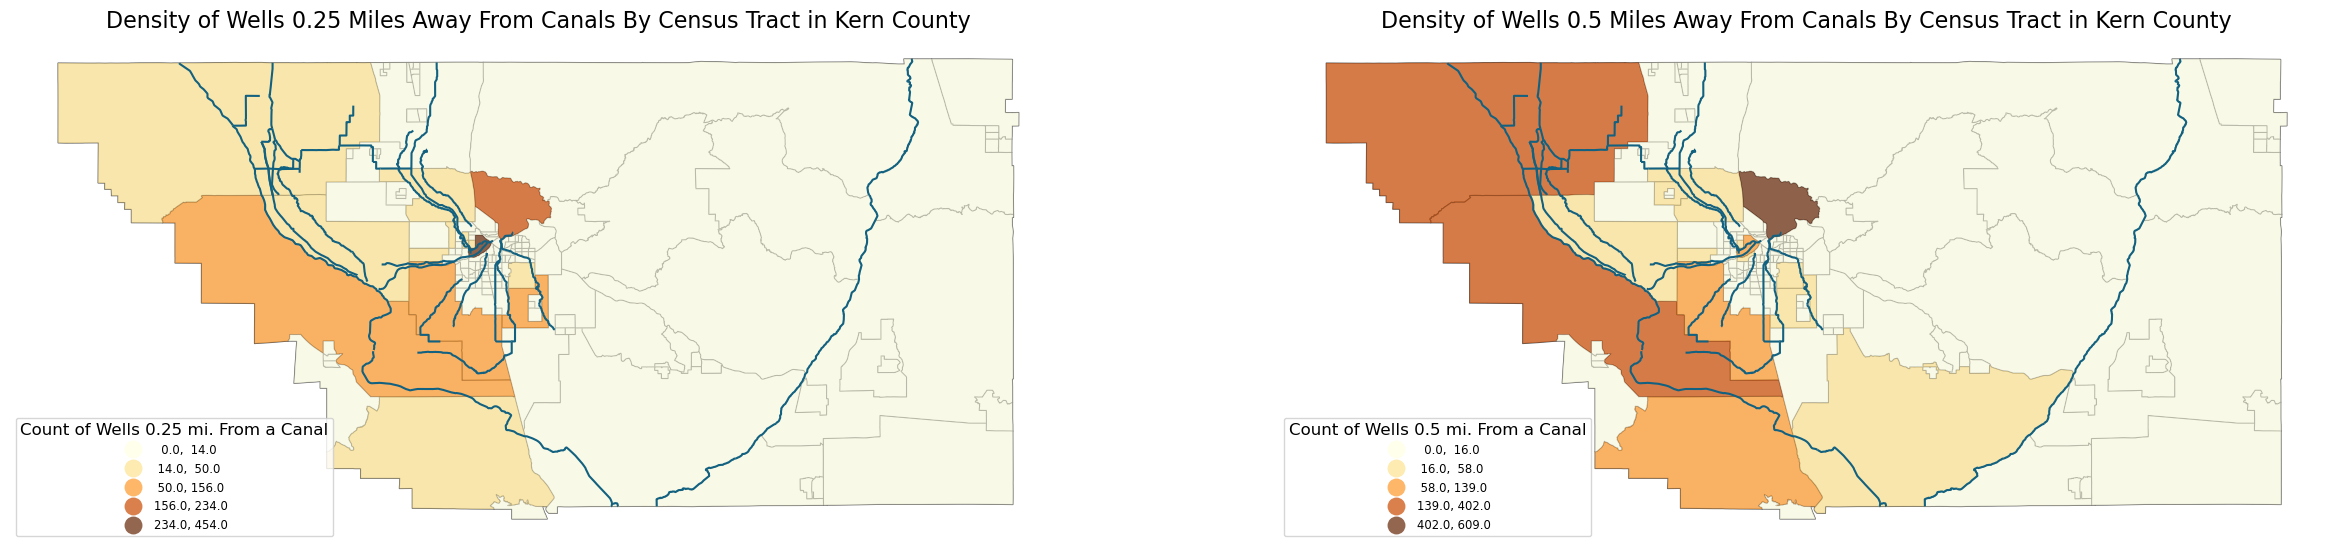

In [126]:
## plotting
fig, axs = plt.subplots(1, 2, figsize=(30,14), sharex=True, sharey=True)
ax1, ax2 = axs

## ax1
# tracts
oilenv.plot(ax=ax1,
            facecolor='#eee',
            edgecolor='#5A5A5A',
            lw=.8)
# canals
canals.plot(ax=ax1,
            linestyle='solid',
            linewidth=1.5,
            color='#126180',
            alpha=1)

# tracts: density of wells .25 miles away from a canal
distancedensity.plot(ax=ax1,
                column='quarter',
                legend=True,
                legend_kwds={'loc':'lower left',
                                 'bbox_to_anchor':(0, 0), 'fmt':"{:.1f}",
                                 'markerscale':1.29, 
                                 'title_fontsize':'large', 
                                 'fontsize':'small'},   
                cmap='YlOrBr',
                scheme='NaturalBreaks',
                alpha=.7)
                
ax1.axis('off')
ax1.set_title("Density of Wells 0.25 Miles Away From Canals By Census Tract in Kern County",fontsize=16)
ax1.get_legend().set_title("Count of Wells 0.25 mi. From a Canal")

## ax1
# tracts
oilenv.plot(ax=ax2,
            facecolor='#eee',
            edgecolor='#5A5A5A',
            lw=.8)
# canals
canals.plot(ax=ax2,
            linestyle='solid',
            linewidth=1.5,
            color='#126180',
            alpha=1)

# tracts: density of wells .5 miles away from a canal
distancedensity.plot(ax=ax2,
                column='half',
                legend=True,
                legend_kwds={'loc':'lower left',
                                 'bbox_to_anchor':(0, 0), 'fmt':"{:.1f}",
                                 'markerscale':1.29, 
                                 'title_fontsize':'large', 
                                 'fontsize':'small'},   
                cmap='YlOrBr',
                scheme='NaturalBreaks',
                alpha=.7)
                
ax2.axis('off')
ax2.set_title("Density of Wells 0.5 Miles Away From Canals By Census Tract in Kern County",fontsize=16)
ax2.get_legend().set_title("Count of Wells 0.5 mi. From a Canal")

# saving
plt.savefig("distancedensitychoropleth.jpg", bbox_inches ='tight')

I want to identify the canals with the highest number of wells that are within .25 or .5 miles of them. I'll create a table to do this.

In [154]:
## table
redcanals = (closest_canal.groupby('CANAL')[['Exposure']]
       .apply(lambda group: group.apply(pd.Series.value_counts))
       .fillna(0)).reset_index()
redcanals

,CANAL,level_1,Exposure
0,BUENA VISTA CANAL,5: 0.50 to 1 mile away,151
1,BUENA VISTA CANAL,6: 0.25 to 0.50 mile away,105
2,BUENA VISTA CANAL,7: 0.25 mile or less away,71
3,BUENA VISTA CANAL,4: 1 to 2 miles away,66
4,BUENA VISTA CANAL,3: 2 to 5 miles away,13
...,...,...,...
84,SHAFTER WASCO ID LATERAL,6: 0.25 to 0.50 mile away,2
85,STINE CANAL,5: 0.50 to 1 mile away,32
86,STINE CANAL,7: 0.25 mile or less away,11
87,STINE CANAL,6: 0.25 to 0.50 mile away,10


In [155]:
## sorting for only the canals whose closest well is within a quarter mile 
redcanals = redcanals[redcanals.level_1 == '7: 0.25 mile or less away']
redcanals.sort_values(by='Exposure',ascending=False,inplace=True)
redcanals

/tmp/ipykernel_58/963900707.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CANAL,level_1,Exposure
13,CALLOWAY CANAL,7: 0.25 mile or less away,371
18,CROSS VALLEY CANAL,7: 0.25 mile or less away,250
45,KERN ISLAND CANAL,7: 0.25 mile or less away,234
10,CALIFORNIA AQUEDUCT,7: 0.25 mile or less away,192
27,EAST SIDE CANAL,7: 0.25 mile or less away,190
70,PIONEER CANAL,7: 0.25 mile or less away,79
2,BUENA VISTA CANAL,7: 0.25 mile or less away,71
30,FRIANT-KERN CANAL,7: 0.25 mile or less away,47
66,NEW RIM DITCH,7: 0.25 mile or less away,15
86,STINE CANAL,7: 0.25 mile or less away,11


Now to graph the results, using the same hex code for this level of exposure as with the previous maps and charts.

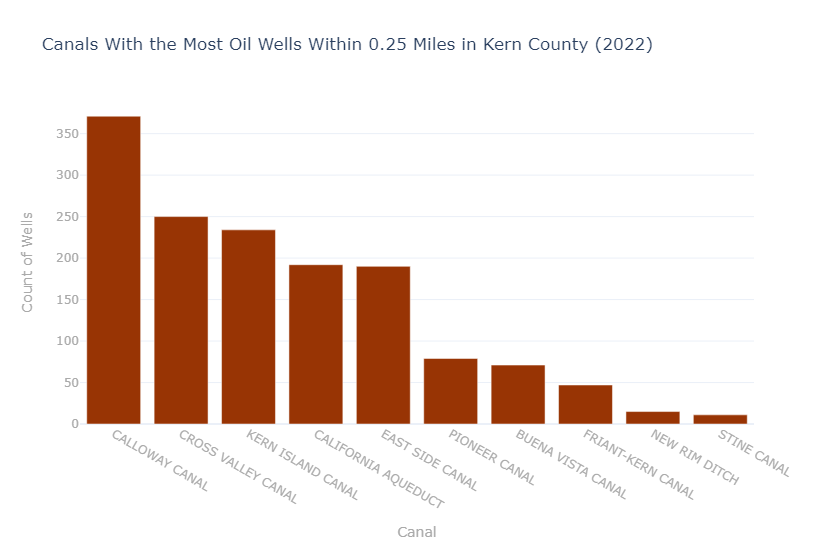

In [156]:
## plotting results

# setting template
import plotly.io as pio
pio.templates.default = "plotly_white"
    # options: seaborn, simple_white, plotly, plotly_white, plotly_dark
    # presentation, xgridoff, ygridoff, gridon, none

# plot 
fig = px.bar(redcanals.head(10),
        x='CANAL',
        y= 'Exposure',
        title="Canals With the Most Oil Wells Within 0.25 Miles in Kern County (2022)",
        text_auto = False,
        height=550,
        width=750,
        color_discrete_sequence =['#983404']*len(redcanals),
                 labels={
                'CANAL': 'Canal',
                'Exposure': 'Count of Wells',
        })

# bar label
fig.update_traces(textposition='outside',textfont_size=10,textfont_color='black')

# axes labels
fig.update_yaxes(title_font_size=14,title_font_color='#aaa',tickfont_color='#aaa',tickfont_size=12)
fig.update_xaxes(title_font_size=14,title_font_color='#aaa',tickfont_color='#aaa',tickfont_size=12)

# show the figure
fig.show()

#save 
fig.write_html("wellsquartertocanal.html")

Honestly, I just ran out of time to figure out a way to create a stacked bar chart only including the wells that are a quarter- and half-mile away from a canal by canal name, or create single bar charts for these two exposure levels in a more efficient/smart way, and am just resetting the "redcanals" table here so I can recreate the same bar chart above for the wells that are a half-mile away.

In [157]:
## table
redcanals = (closest_canal.groupby('CANAL')[['Exposure']]
       .apply(lambda group: group.apply(pd.Series.value_counts))
       .fillna(0)).reset_index()
redcanals

,CANAL,level_1,Exposure
0,BUENA VISTA CANAL,5: 0.50 to 1 mile away,151
1,BUENA VISTA CANAL,6: 0.25 to 0.50 mile away,105
2,BUENA VISTA CANAL,7: 0.25 mile or less away,71
3,BUENA VISTA CANAL,4: 1 to 2 miles away,66
4,BUENA VISTA CANAL,3: 2 to 5 miles away,13
...,...,...,...
84,SHAFTER WASCO ID LATERAL,6: 0.25 to 0.50 mile away,2
85,STINE CANAL,5: 0.50 to 1 mile away,32
86,STINE CANAL,7: 0.25 mile or less away,11
87,STINE CANAL,6: 0.25 to 0.50 mile away,10


In [158]:
## prepping table for bar chart showing count of wells a half-mile away by canal
redcanals = redcanals[redcanals.level_1 == '6: 0.25 to 0.50 mile away']
redcanals.sort_values(by='Exposure',ascending=False,inplace=True)
redcanals

/tmp/ipykernel_58/4091253859.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CANAL,level_1,Exposure
9,CALIFORNIA AQUEDUCT,6: 0.25 to 0.50 mile away,814
44,KERN ISLAND CANAL,6: 0.25 to 0.50 mile away,609
15,CALLOWAY CANAL,6: 0.25 to 0.50 mile away,168
20,CROSS VALLEY CANAL,6: 0.25 to 0.50 mile away,123
1,BUENA VISTA CANAL,6: 0.25 to 0.50 mile away,105
28,EAST SIDE CANAL,6: 0.25 to 0.50 mile away,102
72,PIONEER CANAL,6: 0.25 to 0.50 mile away,63
65,NEW RIM DITCH,6: 0.25 to 0.50 mile away,30
76,POND-POSO CANAL,6: 0.25 to 0.50 mile away,20
47,KERN ISLAND CANAL(CNTRL BRNCH),6: 0.25 to 0.50 mile away,14


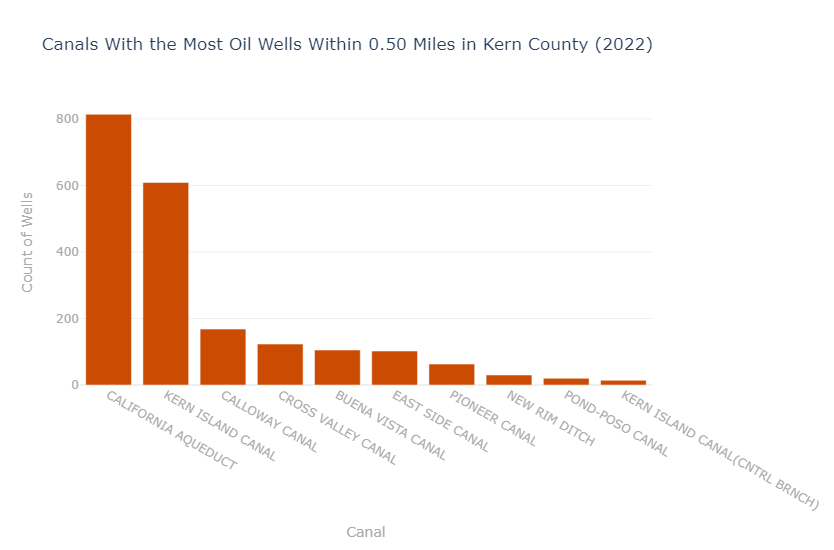

In [159]:
## plotting results

# setting template
import plotly.io as pio
pio.templates.default = "plotly_white"
    # options: seaborn, simple_white, plotly, plotly_white, plotly_dark
    # presentation, xgridoff, ygridoff, gridon, none

# plot 
fig = px.bar(redcanals.head(10),
        x='CANAL',
        y= 'Exposure',
        title="Canals With the Most Oil Wells Within 0.50 Miles in Kern County (2022)",
        text_auto = False,
        height=550,
        width=750,
        color_discrete_sequence =['#cb4b02']*len(redcanals),
                 labels={
                'CANAL':'Canal',
                'Exposure':'Count of Wells',
        })

# bar label
fig.update_traces(textposition='outside',textfont_size=10,textfont_color='black')

# axes labels
fig.update_yaxes(title_font_size=14,title_font_color='#aaa',tickfont_color='#aaa',tickfont_size=12)
fig.update_xaxes(title_font_size=14,title_font_color='#aaa',tickfont_color='#aaa',tickfont_size=12)

# show the figure
fig.show()

#save 
fig.write_html("wellshalftocanal.html")

Now, I want to update the map showing the density of oil wells to canals data by creating a new column in the original canals geodataframe that I can use to color code canals that have the most wells within a quarter and half mile of them.

In [160]:
## updating map to highlight canals with the most wells within a quarter or half mile
canals['closest'] = 'No'
canals.loc[canals['CANAL'] == 'CROSS VALLEY CANAL', 'closest'] = 'Yes'
canals.loc[canals['CANAL'] == 'CALLOWAY CANAL', 'closest'] = 'Yes'
canals.loc[canals['CANAL'] == 'BUENA VISTA CANAL', 'closest'] = 'Yes'
canals.loc[canals['CANAL'] == 'EAST SIDE CANAL', 'closest'] = 'Yes'
canals.loc[canals['CANAL'] == 'CALIFORNIA AQUEDUCT', 'closest'] = 'Yes'
canals.loc[canals['CANAL'] == 'KERN ISLAND CANAL', 'closest'] = 'Yes'
canals.sample(3)

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,CANAL24CA_,CANAL24CA1,CANAL,FED,STATE,geometry,coords,closest
15,0,0,0,0,3415.919922,57,7397,None,0,0,"LINESTRING (-119.34939 35.57248, -119.34048 35...","[[35.57248203554991, -119.34939181970731], [35...",No
46,0,0,0,0,6548.129883,181,7373,KERN RIVER FLOOD CANAL,0,0,"LINESTRING (-119.62977 35.55801, -119.62975 35...","[[35.55800670443592, -119.62976879788938], [35...",No
35,0,0,0,0,7747.319824,170,7477,EAST SIDE CANAL,0,0,"LINESTRING (-118.90352 35.26056, -118.90343 35...","[[35.26055893836051, -118.90352002117223], [35...",Yes


Now remapping.

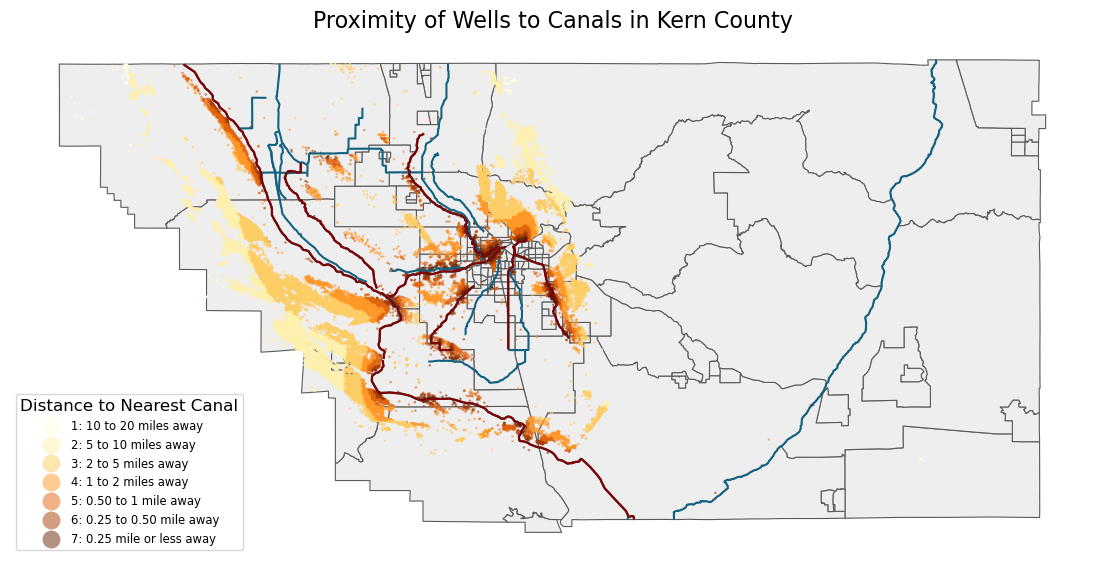

In [133]:
## plotting
fig,ax = plt.subplots(figsize=(14,12))

# tracts
oilenv.plot(ax=ax,
            facecolor='#eee',
            edgecolor='#5A5A5A',
            lw=.8)
# canals
canals.plot(ax=ax,
            linestyle='solid',
            linewidth=1.5,
            color='#126180',
            alpha=1)

# canals with the most oil wells close to them
canals[canals['closest'] == "Yes"].plot(ax=ax,
            linestyle='solid',
            linewidth=1.6,
            color='maroon',
            alpha=1)

# OG wells: color coded
kern_wells.plot(ax=ax,
                column='Exposure',
                marker='.',
                markersize=3,
                legend=True,
                legend_kwds={'loc':'lower left',
                                 'bbox_to_anchor':(0, 0), 'fmt':"{:.1f}",
                                 'markerscale':1.29, 
                                 'title_fontsize':'large', 
                                 'fontsize':'small'},   
                cmap='YlOrBr',
                alpha=.5)
                
ax.axis('off')
ax.set_title("Proximity of Wells to Canals in Kern County",fontsize=16)
ax.get_legend().set_title("Distance to Nearest Canal")

# saving
plt.savefig("activewellstocanalsproximity2.jpg", bbox_inches ='tight')

One last thing -- is there any connection between the aquifers in the County that the EPA has provided exemptions for the oil industry to use in their production activities?

In [161]:
## loading aquifer data
aquifers = gpd.read_file('Post Primacy Aquifer Exemptions.shp')

In [162]:
aquifers.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Name        42 non-null     object  
 1   Field_Labe  42 non-null     object  
 2   Zone_Label  42 non-null     object  
 3   Formation   42 non-null     object  
 4   Zone        42 non-null     object  
 5   Pool        42 non-null     object  
 6   Acreage     42 non-null     float64 
 7   DepthMin_Z  42 non-null     int64   
 8   DepthMax_Z  42 non-null     int64   
 9   ThicknessM  42 non-null     int64   
 10  Thicknes_1  42 non-null     int64   
 11  USDW_MinDe  42 non-null     int64   
 12  USDW_MaxDe  42 non-null     int64   
 13  TDS_Min     42 non-null     int64   
 14  TDS_Max     42 non-null     int64   
 15  Boron_Min   42 non-null     float64 
 16  Boron_Max   42 non-null     float64 
 17  Exemption_  42 non-null     object  
 18  Last_Edit_  30 non-null     object  
 19  Co

In [163]:
aquifers.sample(4)

,Name,Field_Labe,Zone_Label,Formation,Zone,Pool,Acreage,DepthMin_Z,DepthMax_Z,ThicknessM,...,County,Inj_Zone,Lithology,Injectate,SHAPE_Leng,CA_ID,Shape_Le_1,Shape_Area,Approve,geometry
19,PosoCreek_Chanac_McVanArea,Poso Creek Exemption,Chanac Exempt Area,Chanac,Chanac,Chanac,1532.0,35,-520,90,...,Kern,Chanac Formation,"Medium to coarse-grained, massive unsorted san...",None,12642.573307,TBD,12642.573307,6.197693e+06,5/4/2018,"POLYGON ((87200.590 -268689.723, 87363.190 -26..."
36,MidwaySunset_SpellacySands_NoOverlap,Midway Sunset Exemption,Spellacy Sands Exempt Area,Monterey,Spellacy Sands,Spellacy Sands,4315.0,392,1268,0,...,Kern and San Luis Obispo,Spellacy Sands,"Arkosic sands containing quartz, feldspars, an...",None,67784.239571,TBD,67784.239571,1.745344e+07,5/30/2019,"MULTIPOLYGON (((38567.809 -314741.249, 38727.2..."
26,NorthBelridge_Tulare,North Belridge Exemption,Tulare Exempt Area,Tulare,Tulare,Tulare,332.8,640,-475,350,...,Kern,Tulare Formation,Sands interbedded with low-permeability clay l...,None,11806.015891,TBD,11806.015891,1.345595e+06,9/28/2018,"MULTIPOLYGON (((21270.604 -276707.429, 21348.9..."
28,LostHills_Tulare,Lost Hills Exemption,Tulare Exempt Area,Tulare,Tulare,Tulare,1778.0,0,160,100,...,Kern,Tulare Formation,Interbedded sequence of poorly consolidated co...,None,26381.641852,TBD,26381.641852,7.315238e+06,5/20/2019,"MULTIPOLYGON (((19290.286 -257157.962, 19311.6..."


In [164]:
aquifers['County'].value_counts()

Kern                        28
Kern and San Luis Obispo     6
Monterey                     4
Fresno                       2
Alameda                      1
San Luis Obispo              1
Name: County, dtype: int64

In [165]:
## subsetting only for Kern
aquifers = aquifers[aquifers.County == 'Kern']
aquifers.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 28 entries, 2 to 41
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Name        28 non-null     object  
 1   Field_Labe  28 non-null     object  
 2   Zone_Label  28 non-null     object  
 3   Formation   28 non-null     object  
 4   Zone        28 non-null     object  
 5   Pool        28 non-null     object  
 6   Acreage     28 non-null     float64 
 7   DepthMin_Z  28 non-null     int64   
 8   DepthMax_Z  28 non-null     int64   
 9   ThicknessM  28 non-null     int64   
 10  Thicknes_1  28 non-null     int64   
 11  USDW_MinDe  28 non-null     int64   
 12  USDW_MaxDe  28 non-null     int64   
 13  TDS_Min     28 non-null     int64   
 14  TDS_Max     28 non-null     int64   
 15  Boron_Min   28 non-null     float64 
 16  Boron_Max   28 non-null     float64 
 17  Exemption_  28 non-null     object  
 18  Last_Edit_  22 non-null     object  
 19  Co

In [166]:
aquifers.crs

<Derived Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [168]:
## adjusting projection
aquifers = aquifers.to_crs("EPSG:4326")

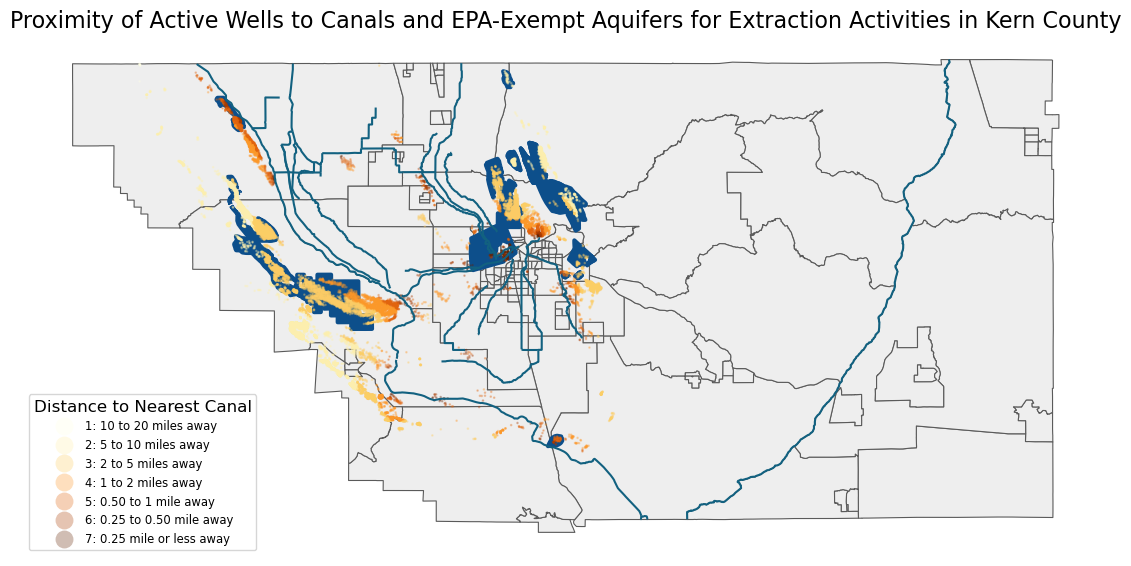

In [169]:
## plotting
fig,ax = plt.subplots(figsize=(14,12))

# tracts
oilenv.plot(ax=ax,
            facecolor='#eee',
            edgecolor='#5A5A5A',
            lw=.8)
#aquifers
aquifers.plot(ax=ax,
              facecolor='#0D4F8B',
              edgecolor='#0D4F8B',
              lw=3)

# canals
canals.plot(ax=ax,
            linestyle='solid',
            linewidth=1.5,
            color='#126180',
            alpha=1)

# OG wells: color coded
kern_wells[kern_wells.WellStatus == 'Active'].plot(ax=ax,
                column='Exposure',
                marker='.',
                markersize=3,
                legend=True,
                legend_kwds={'loc':'lower left',
                                 'bbox_to_anchor':(0, 0), 'fmt':"{:.1f}",
                                 'markerscale':1.29, 
                                 'title_fontsize':'large', 
                                 'fontsize':'small'},   
                cmap='YlOrBr',
                alpha=.3)
                
ax.axis('off')
ax.set_title("Proximity of Active Wells to Canals and EPA-Exempt Aquifers for Extraction Activities in Kern County",fontsize=16)
ax.get_legend().set_title("Distance to Nearest Canal")

# saving
plt.savefig("activewellscanalsaquifers.jpg", bbox_inches ='tight')

There are quite a lot of active wells situated on these aquifers, particularly on the westernmost regions of the County and just north of Bakersfield.

## Assignment Group Information

**Group name**: Environmental Justice In Kern County

**Members**: Yesenia Becerra, Dinah Dominguez, Melody Ng, Nick Stewart-Bloch